# Logistic Regression, Numeric and Categorical Features Predict Probability

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../data'))
import pathlib
import json
from datetime import datetime

import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# 1. Loading

In [2]:
data_root = pathlib.Path('../data')

In [3]:
all_json_paths = list(data_root.glob('*.json'))
all_json_paths = [str(path) for path in all_json_paths]

In [4]:
all_json_paths

['..\\data\\Kickstarter_2019-01-17T03_20_02_630Z.json',
 '..\\data\\Kickstarter_2019-02-14T03_20_04_734Z.json',
 '..\\data\\Kickstarter_2019-03-14T03_20_12_200Z.json',
 '..\\data\\Kickstarter_2019-04-18T03_20_02_220Z.json',
 '..\\data\\Kickstarter_2019-05-16T03_20_20_822Z.json',
 '..\\data\\Kickstarter_2019-06-13T03_20_35_801Z.json',
 '..\\data\\Kickstarter_2019-07-18T03_20_05_009Z.json',
 '..\\data\\Kickstarter_2019-08-15T03_20_03_022Z.json']

In [5]:
data = []
for line in open(all_json_paths[0], 'r', encoding='utf8'):
    data.append(json.loads(line))
    
data = [record['data'] for record in data]
raw = pd.DataFrame.from_records(data)

# 2. Preprocessing

In [6]:
def preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Naive preprocessing the input data by dropping samples that still have the campaign running,
    impute durations and categories, dropping unnecessary features, and one-hot encoding for
    training.
    
    Parameters
    ----------
    df : pandas.DataFrame
    
    Returns
    ----------
    df : pandas.DataFrame
    """
    # get durations by taking the difference between launch and deadline and transform
    # the seconds integer into days.
    df['durations'] = round((df.deadline - df.launched_at)/(60*60*24))
    
    # parse the category feature's json format and extract the first level categories
    df['cat_slug'] = df.category.apply(lambda x: x['slug'].split('/')[0])

    # map states to 1 for success and 0 for others. Also will drop all 'live' records.
    state_dict = {'successful':1, 'failed':0, 'canceled':0, 'suspended':0}
    df = df.replace({"state": state_dict})
    df = df[df.state != 'live']

    # drop unused features
    df = df[['name', 'blurb', 'goal', 'country', 'durations', 'cat_slug', 'state']]
    
    return df

In [7]:
cols_names = raw.columns.to_list()

In [8]:
df = raw.copy()
df = preproc(df)
X_col = ['goal', 'durations', 'country', 'cat_slug']
X = df[X_col]
# need to add .astype('int') to turn it y into int from object. otherise sklearn wont work
# https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
y = df.state.astype('int')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.15, random_state=45)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((172516, 4), (30444, 4), (172516,), (30444,))

# 3. Training

In [10]:
def logistic_regression(X, y):
    """
    Logistic regression model using GridSearchCV. Since GridSearchCV does cross validation internally,
    we choose not to split X into training and validation set. We choose to do 5 fold cross validation
    during GridSearch. With that, data issplit three ways: 0.68 train, 0.17 validation, and 0.15 test.
    We will continue to use OneHotEncoding and StandardScaler in our training pipeline. Since some of
    the categorical features have very high cardinality, e.g., funder with 1898 categories, we choose
    to take only the top 6 with high cardinality to reduce training time.
    
    Parameters
    ----------
    X : training data
    y : target data
    
    Returns
    ----------
    search.best_estimator : the best Logistic Regression model produced by the GridSearchCV
    """

    logreg = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=45, max_iter=500)
    encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
    scaler = StandardScaler(with_mean=False)

    pipe = Pipeline(steps=[('encoder', encoder),
                           ('scaler', scaler),
                           ('logreg', logreg)
                           ])
    
    param_grid = {
        'logreg__C': np.power(10.0, np.arange(3, 10)),
    }
    
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
    %time search.fit(X, y)
    print("Training Score (accuracy): {}".format(search.best_score_))
    print("Best Parameters: {}".format(search.best_params_))
    
    return search.best_estimator_

In [11]:
model = logistic_regression(X_train, y_train)

Wall time: 23.2 s
Training Score (accuracy): 0.6818729856940805
Best Parameters: {'logreg__C': 1000.0}


In [12]:
model.score(X_test, y_test)

0.6805610300880305

# 4. Saving the Model

In [13]:
filename = '../models/20191022_logreg_68.sav'
pickle.dump(model, open(filename, 'wb'))

# 5. Inferencing

In [14]:
import json
test1 = '''{"name": "asdfasdfasdf", "blurb": "asdfasdfasdfadsdfasdfadfasdf", "goal": 800.0, "country": "US", "duration":15.0, "category": "fashion"}'''
test2 = '''{"goal": 800.0, "country": "US", "duration":15.0, "category": "fashion"}'''

In [15]:
test1j = json.loads(test2)
test1df = pd.DataFrame.from_records(test1j, index=[0])
model.predict_proba(test1df.to_numpy())[:,1]

array([0.5147114])

# 5.1 Distributionof testing data
Look at the distribution of the prediction for the probability of success.

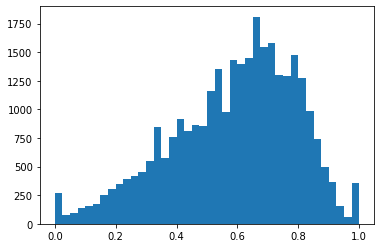

In [16]:
y_pred = model.predict_proba(X_test)
plt.hist(y_pred[:,1], bins=40);

In [17]:
print(f"Highest probability w/in test {np.max(y_pred[:,1])}, highest prob sample location is {np.argmax(y_pred[:,1])}")
x_high = X_test[np.argmax(y_pred[:,1])]
print(x_high)
print(f"The highest probabilty sample is {x_high}, shape is {x_high.shape})")

Highest probability w/in test 0.9999999999999978, highest prob sample location is 6371
[2011.0 67.0 'US' 'publishing']
The highest probabilty sample is [2011.0 67.0 'US' 'publishing'], shape is (4,))


In [18]:
model.predict_proba(x_high.reshape(1, -1))

array([[2.22044605e-15, 1.00000000e+00]])

In [19]:
model.predict_proba(X_test[np.argmax(y_pred[:,1])].reshape(1, -1))

array([[2.22044605e-15, 1.00000000e+00]])

In [20]:
goal, duration, country, category = 2011.0, 67.0, 'US', 'publishing'

In [22]:
test3 = '''{"goal": 2011, "country": "US", "duration":67, "category": "publishing"}'''
test3j = json.loads(test3)
test3df = pd.DataFrame.from_records(test3j, index=[0], columns=['goal', 'country', 'duration', 'category'])
model.predict_proba(test3df.to_numpy())[:,1]

array([0.99999996])